## Importing Packages ##

In [7]:
import os
import sys
import subprocess
import tempfile
import random
from itertools import compress
import os.path as op
import numpy as np
import skimage.io as sio
import pandas as pd
import importlib
import math
from math import sqrt
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn import svm
import diff_classifier
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

**Split large TIFF into smaller files for ImageJ**

In [24]:
tiffname = 'P10F_NT_4DIV_40nm_slice_2_cortex_vid_2.tif'

In [29]:
os.getcwd()

In [31]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/')
test = sio.imread('TIFS/'+tiffname)
oshape = test.shape
oshape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/TIFS/P10F_NT_4DIV_40nm_slice_2_cortex_vid_2.tif'

Splits a TIFF file from a 1024x1024 FOV into 4 files

In [27]:
test2 = np.zeros((oshape[0], 1024, 1024), dtype=test.dtype)

test2[0:oshape[0], 0:oshape[1], :] = test

new_image = np.zeros((oshape[0], 512, 512), dtype=test.dtype)
names = []

for row in range(2):
    for col in range(2):
        new_image = test2[:, row*512:(row+1)*512, col*512:(col+1)*512]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_0_0.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_0_1.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_0_2.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_0_3.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_1_0.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_vid_2_1_1.tif is a low contrast image
  sio.imsave(current, new_image)
<ipython-input-27-e26019535814>:12: UserWarning: P10F_NT_4DIV_40nm_slice_2_cortex_

Splits a TIFF file from a 2028x2048 FOV into 16 files

In [ ]:
test2 = np.zeros((oshape[0], 2044, 2048), dtype=test.dtype)

test2[0:oshape[0], 0:oshape[1], :] = test

new_image = np.zeros((oshape[0], 512, 512), dtype=test.dtype)
names = []

for row in range(4):
    for col in range(4):
        new_image = test2[:, row*512:(row+1)*512, col*512:(col+1)*512]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

## Defining filenames for all videos ##

In [221]:
filename = '012223_P10F_8DIV_1uM_prolonged_thal_1'
rows = 2
cols = 2
ires = (512, 512)
frames = 651
names = []
for i in range(0,rows):
    for j in range(0,cols):
        names.append('{}_{}_{}.tif'.format(filename, i, j))
names

['012223_P10F_8DIV_1uM_prolonged_thal_1_0_0.tif',
 '012223_P10F_8DIV_1uM_prolonged_thal_1_0_1.tif',
 '012223_P10F_8DIV_1uM_prolonged_thal_1_1_0.tif',
 '012223_P10F_8DIV_1uM_prolonged_thal_1_1_1.tif']

## Calculating MSDs and features for the videos that have been tracked. This uses the Traj .csv files and generates an msd and features .csv file for the videos being quantified. It uses the multiple small vid Traj .csv files to generate a single msd and features .csv file. Essentially, this runs the kn.assemble_msds() function ##

In [220]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Slice MPT/012223_P10F_1uM_prolonged_thal_Traj_csv')
msd_file = 'msd_{}.csv'.format(filename)
ft_file = 'features_{}.csv'.format(filename)

counter = 0
for name in names:
    try:
        row = int(name.split(filename)[1].split('.')[0].split('_')[1])
        col = int(name.split(filename)[1].split('.')[0].split('_')[2])

        traj_file = "Traj_{}_{}_{}.csv".format(filename, row, col)
        local_name = traj_file
        
        if counter == 0:
            to_add = pd.read_csv(local_name)
            del to_add['LABEL']
            del to_add['POSITION_Z']
            del to_add['POSITION_T']
            del to_add['RADIUS']
            del to_add['VISIBILITY']
            del to_add['MANUAL_SPOT_COLOR']
            del to_add['MEDIAN_INTENSITY_CH1']
            del to_add['MIN_INTENSITY_CH1']
            del to_add['MAX_INTENSITY_CH1']
            del to_add['TOTAL_INTENSITY_CH1']
            del to_add['STD_INTENSITY_CH1']
            del to_add['CONTRAST_CH1']
            to_add = to_add.drop([0,1,2,3])
            to_add = to_add.rename(columns={'ID':'Spot_ID','TRACK_ID':'Track_ID', 'QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})
            to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
            to_add = to_add.astype('float64')
            
            partids = to_add.Track_ID.unique()
            counter = 0
            for partid in partids:
                to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                counter = counter +1
            to_add['X'] = to_add['X'] + ires[0]*col
            to_add['Y'] = ires[1]-to_add['Y']+ires[1]*(rows-1-row)
            merged = msd.all_msds2(to_add, frames=frames)
            print("Finished with row 0 col 0")
            
        else:
            if merged.shape[0] > 0:
                to_add = pd.read_csv(local_name)
                to_add = pd.read_csv(local_name)
                del to_add['LABEL']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_SPOT_COLOR']
                del to_add['MEDIAN_INTENSITY_CH1']
                del to_add['MIN_INTENSITY_CH1']
                del to_add['MAX_INTENSITY_CH1']
                del to_add['TOTAL_INTENSITY_CH1']
                del to_add['STD_INTENSITY_CH1']
                del to_add['CONTRAST_CH1']
                to_add = to_add.drop([0,1,2,3])
                to_add = to_add.rename(columns={'ID':'Spot_ID','TRACK_ID':'Track_ID', 'QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})
                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')
                
                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) +1
                
            else:
                to_add = pd.read_csv(local_name)
                del to_add['Label']
                del to_add['POSITION_Z']
                del to_add['POSITION_T']
                del to_add['RADIUS']
                del to_add['VISIBILITY']
                del to_add['MANUAL_SPOT_COLOR']
                del to_add['MEDIAN_INTENSITY_CH1']
                del to_add['MIN_INTENSITY_CH1']
                del to_add['MAX_INTENSITY_CH1']
                del to_add['TOTAL_INTENSITY_CH1']
                del to_add['STD_INTENSITY_CH1']
                del to_add['CONTRAST_CH1']
                to_add = to_add.drop([0,1,2])
                to_add = to_add.rename(columns={'ID':'Spot_ID','TRACK_ID':'Track_ID', 'QUALITY':'Quality','FRAME':'Frame', 'POSITION_X':'X','POSITION_Y':'Y', 'MEAN_INTENSITY_CH1':'Mean_Intensity', 'SNR_CH1':'SN_Ratio'})
                to_add.sort_values(['Track_ID', 'Frame'], ascending=[1,1])
                to_add = to_add.astype('float64')
                
                partids = to_add.Track_ID.unique()
                counter = 0
                for partid in partids:
                    to_add.loc[to_add.Track_ID == partid, 'Track_ID'] = counter
                    counter = counter +1
                to_add['X'] = to_add['X'] + ires[0]*col
                to_add['Y'] = ires[1] - to_add['Y'] + ires[1]*(rows-1-row)
                to_add['Track_ID'] = to_add['Track_ID']
        
            merged = merged.append(msd.all_msds2(to_add, frames=frames))
            print('Done calculating MSDs for row {} and col {}'.format(row, col))
    
        counter = counter +1
    
        merged.to_csv(msd_file)
        merged_ft = ft.calculate_features(merged)
        merged_ft.to_csv(ft_file)
    
    except pd.errors.EmptyDataError:
        print('Found empty file : {}'.format(name))
                

FileNotFoundError: [Errno 2] No such file or directory: 'Traj_012223_P10F_8DIV_1uM_prolonged_thal_2_0_0.csv'

msd_012223_P10F_8DIV_1uM_prolonged_thal_1.csv
Plotted 012223_P10F_8DIV_1uM_prolonged_thal_1 trajectories successfully.
Successfully generated trajectory plot for 012223_P10F_8DIV_1uM_prolonged_thal_1
Successfully generated csv files for 012223_P10F_8DIV_1uM_prolonged_thal_1


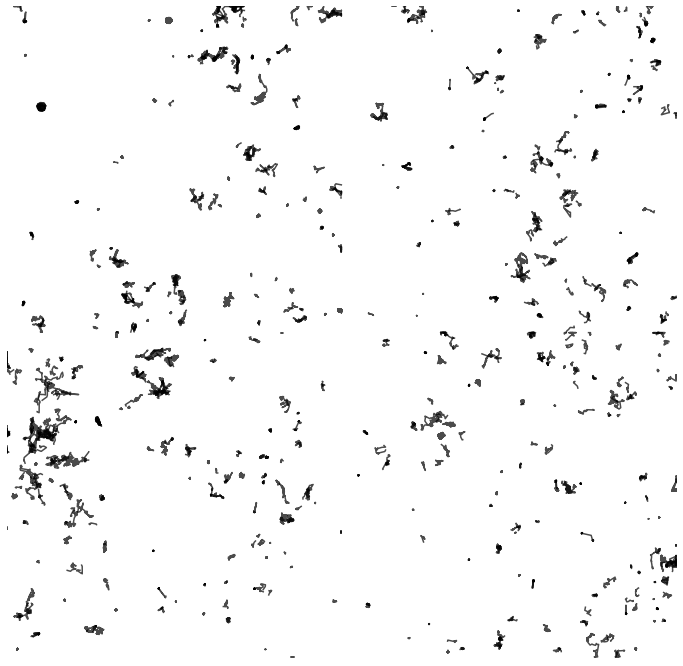

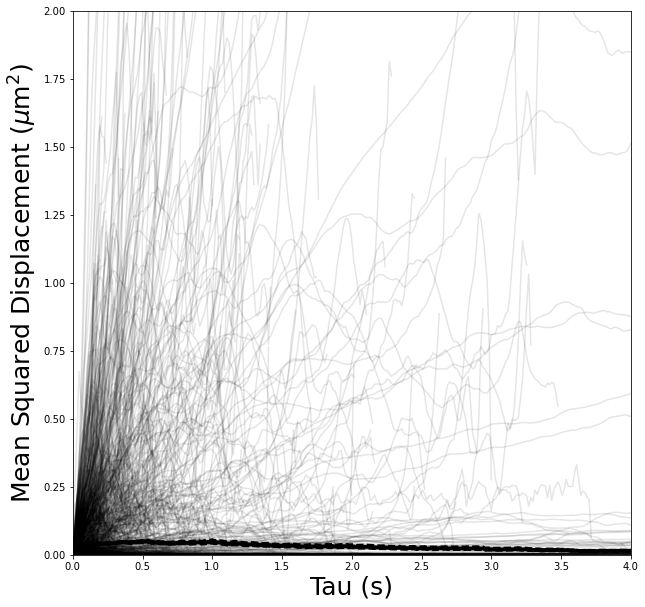

In [222]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Slice MPT/012223_P10F_1uM_prolonged_thal_Traj_csv')
prefix = filename
msds = 'msd_{}.csv'.format(prefix)
feat = 'features_{}.csv'.format(prefix)
print(msds)
hm.plot_trajectories(prefix, resolution=512, rows=2, cols=2, upload=False, figsize=(12, 12), bucket = 'mckenna.data')
print('Successfully generated trajectory plot for {}'.format(prefix))
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=4, y_range=2, umppx=0.07, fps=67, upload=False, bucket='mckenna.data')
print('Successfully generated csv files for {}'.format(prefix))